# Pre-processing

Combinines all vehicular trace data into a single .csv, which can be fed to the existing ML pipeline.

### Specific new problems that had to be solved

* In traces 40x, the 802.11n and ac routers didn't log channel busy time. We approximate channel util. based on x,y coordinates and nr. of active clients. [Details here.](#Extract-channel-utilization-data-from-channel-busy-time-logs)
* Since the `iw survey dump` command didn't work on 802.11ad interfaces, 802.11ad channel utilization is based on custom calculations based on WLAN frame airtime, as described [here](https://www.usenix.org/legacy/event/imc05/tech/full_papers/jardosh/jardosh_new.pdf) and adapted to 802.11ad frames. **This still requires double-checking and improvement.**
* 802.11ad RSSI is retrieved from sector sweep feedback frames, and assumes values that are very different from RSSIs of 802.11n and 802.11ac. [Details here.](#802.11ad-.pcap-file-pre-processing)

### Description of final log

Some fields have been added `[NEW]` or updated `[UPDATED]` when compared with previous version.

* **systime** : system time (1 Hz resolution) that this row refers to. All node clocks were synchronized through NTP.
* **traceNr** `[NEW]` : nr. of the trace the row belongs to. 
* **lon** `[NEW]` : longitude (in degrees) reported by the receiver's GPS at `systime`
* **lat** `[NEW]` : latitude reported by the receiver's GPS at `systime`
* **receiverAlt** : altitude (in meters) reported by the receiver's GPS at `systime`
* **receiverX** : x coordinate of the receiver's position when space is discretized as a Cartesian plane and the sender is set to be the origin of the coordinate system. The x axis corresponds to east-west (positive values are east, negative values are west). Unit is meters.
* **receiverY** : y coordinate of the receiver's position when space is discretized as a Cartesian plane
* **receiverDist** : distance (in meters) of receiver to ap(s)
* **receiverSpeed** : speed (in m/s) reported by the receiver's GPS at `systime`
* **receiverId** : system-specific id for the client (in the vehicle)
* **senderId** : system-specific id for the ap serving the client (side of the road)
* **isIperfOn** : 1 if row's `systime` corresponds to a period where iperf is known to have been running on the receiver side. **In this clase, our `gluten` app was always on, so this column is meaningless.**
* **isInLap** : 1 if this row's systime has been marked as being part of a time period where clients were doing laps around the APs, 0 otherwise. **This needs improvement.**
* **rssiMean** `[UPDATED]` : the mean of the RSSI (Received Signal Strength Indicator) values of frames received by the client from the ap during the 1-second period systime period the row refers to. **For 802.11ad, we retrieve RSSI from sector sweep feedback frames.** nan values are filled with -100 dBm.
* **channelFreq** : center frequency of the WiFi channel used, in MHz.
* **channelBw** : bandwidth of the WiFi channel used, in MHz.
* **channelUtil** `[UPDATED]` : percentage of time the wireless medium was sensed to be busy during the 1-second period systime period the row refers to. **In traces 40x, the 802.11n and ac routers didn't log channel busy time, and as such we had to approximate channel util. based on x,y coordinates and nr. of active clients.**
* **wifiType** `[NEW]` : 802.11 type (e.g., n, ac or ad).
* **nrClients** `[NEW]` : nr. of parallel clients operating in `wifiType` mode, on the same channel and bandwidth as `receiverId`.
* **dataRateMedian** `[NEW]` : the median of the bitrate values of frames received by the client from the ap during the 1-second period systime period the row refers to.
* **dataRateMean** : the mean of the bitrate values of frames received by the client from the ap during the 1-second period systime period the row refers to.
* **nBytesReceived** : total number of bytes received by the client from the ap during the 1-second period systime period the row refers to.
* **tghptConsumer** `[NEW]` : throughput reported by the receiving end of the `gluten` app, during the 1-second period systime period the row refers to.
* **nRetries** `[NEW]` : nr. of WLAN-level re-transmissions on 1 second period
* **meanBeaconRssi** `[NEW]` : mean RSSI measured from beacons in 1 second period. nan values are filled with -100 dBm.
* **meanInterBeaconTime** `[NEW]` : mean interval between consecutive beacons, within 1 second period. nan values are filled with 1 sec.
* **nBeacons** `[NEW]` : total nr. of beacons received by client within 1 second period.

In [2]:
import os
import glob
import sys
import pandas as pd
import numpy as np
import warnings
import hashlib
import geopandas as gp
import mapping.openstreetmap as osm
import mapping.utils
import matplotlib
import matplotlib.pyplot as plt
import timeit
import shapely
import contextily as ctx
import numpy as np

from collections import defaultdict

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.5f}'.format)

In [3]:
base_dir = '/Volumes/data/vehicular-traces-gaia'
trace_nrs = ['302', '303', '304', '401', '402', '403', '404', '405']

# intersection coords (espg:4326)
LAT  = 41.111937
LON = -8.631084
# N, S, W, E limits of bbox
LATN = LAT + 0.001
LATS = LAT - 0.001
LONE = LON + 0.001
LONW = LON - 0.001
# intersection coords (espg:3857)
LAT_3857 = 5028862.95
LON_3857 = -960807.88

# ap info & location
ap_info = {
    'ap-n'  : {'bw' : 20.0, 'freq' : 2437.0},
    'ap-ac' : {'bw' : 40.0, 'freq' : 5200.0},
    'ap-ad' : {'bw' : 2160.0, 'freq' : 60480.0},
}
ap_coords = {'lat' : 41.111879, 'lon' : -8.631146}

# add cartesian x, y coordinates (in meters) based on lat, lon
# origin (0, 0) is ap location
def add_cartesian(data, ap_loc = ap_coords):
    n = len(data)
    ap_lat = np.array([ap_loc['lat']] * n)
    ap_lon = np.array([ap_loc['lon']] * n)
    
    data['receiverX'] = mapping.utils.gps_to_dist(ap_lat, data['lon'], ap_lat, ap_lon)
    sign = (np.abs(data['lon']) - np.abs(ap_lon)) / np.abs((np.abs(data['lon']) - np.abs(ap_lon)))
    data['receiverX'] *=  sign
    
    data['receiverY'] = mapping.utils.gps_to_dist(data['lat'], ap_lon, ap_lat, ap_lon)
    sign = (np.abs(data['lat']) - np.abs(ap_lat)) / np.abs((np.abs(data['lat']) - np.abs(ap_lat)))
    data['receiverY'] *=  sign
    
    data['receiverDist'] = mapping.utils.gps_to_dist(data['lat'], data['lon'], ap_lat, ap_lon)
    
# interoplate subset columns over time, to cover gaps
# uses pd.DataFrame.interpolate(method = 'time')
def interpol(data, subset, timedate_column = 'systime', limit = 0):
    # FIXME : still don't know how to do this without copying, hence the variable '_data'
    to_interpol = data[[timedate_column] + subset]
    # use pandas native time-based interpolation, which requires a datetime index
    # FIXME : the type of interpolation should be defined as a parameter later on
    to_interpol['datetime'] = pd.to_datetime(to_interpol[timedate_column], unit = 's')
    to_interpol.set_index(['datetime'], inplace = True)
    # limit : max. nr. of consecutive nan to fill
    if limit > 0:
        to_interpol.interpolate(method = 'time', inplace = True, limit_area = 'inside', limit = limit)
    else:
        to_interpol.interpolate(method = 'time', inplace = True, limit_area = 'inside')
        
    # update subset columns w/ the interpolated values
    data.update(to_interpol[subset].reset_index(drop = True))

# calculates channel util. (%) based on channel busy time data, as reported by 'iw survey dump' command
def get_channel_util(data, force_simple = False):
    
    data = data.dropna(subset = ['cat', 'cbt']).reset_index(drop = True)
    
    # reference:
    #   - cat : channel active time : amount of time in ms the radio spent on the channel
    #   - cbt : channel busy time   : amount of time the primary channel was sensed busy
    #   - crt : channel rcv time    : amount of time the radio spent receiving data 
    #   - ctt : channel tx time     : amount of time the radio spent transmitting data
    data['timestamp'] = data['timestamp'].astype(int)

    # for debugging purposes, timestamps in str format
    # data['timestamp-str'] = [ str(ts) for ts in data['timestamp'] ]
    
    # FIXME: from a quick 'eyeballed' analysis of the data, 
    # we observe that cat and cbt increase monotonically over some period.
    # this means cat and cbt accumulate over the period.
    # after each period, the cat and cbt values overflow, and a monotonically increasing period starts again.
    
    # as such, we calculate channel util. over segments of increasingly monotonic cat and cbt
    data['block'] = ((data['cat'] - data['cat'].shift(1)) < 0.0).astype(int).cumsum()
    
    channel_util = pd.DataFrame()
    channel_util_groups = data.groupby(['block'])
    for name, group_data in channel_util_groups:
        if (len(group_data) > 1) & (not force_simple):
            group_data['diff-cbt'] = group_data['cbt'] - group_data['cbt'].shift(1)
            group_data['diff-cat'] = group_data['cat'] - group_data['cat'].shift(1)
            group_data['ch-util'] = (group_data['diff-cbt'].astype(float) / group_data['diff-cat'].astype(float)) * 100.0            
        else:
            group_data['ch-util'] = (group_data['cbt'].astype(float) / group_data['cat'].astype(float)) * 100.0            
            
        channel_util = pd.concat([channel_util, group_data[['timestamp', 'freq', 'cat', 'cbt', 'ch-util', 'block']]])

    channel_util = channel_util.dropna(subset = ['ch-util']).reset_index(drop = True)
    return channel_util

## Extract channel utilization data from channel busy time logs

### Generate channel utilization .csv files for each {trace, ap} pair

In [45]:
# total nr. of clients per trace nr. (including background clients)
trace_info = {
    '301' : {'nr-clients' : 1},
    '302' : {'nr-clients' : 1},
    '303' : {'nr-clients' : 2},
    '304' : {'nr-clients' : 3},
    '401' : {'nr-clients' : 1},
    '402' : {'nr-clients' : 2},
    '403' : {'nr-clients' : 2},
    '404' : {'nr-clients' : 2},
    '405' : {'nr-clients' : 2},
}

# FIXME: processing of cbt .csv files different form 30* and 40* traces,
# since in 40* traces the unifi-ac routers didn't log cbt due to an error

# 30* traces : use cbt.*.csv files in 'b1/it-unifi-00* folders
# cbt data files
cbt_files = {
    'ap-n' : {
        'folder' : 'b1/it-unifi-003', 
        'file' : 'cbt.wlan1.*.csv'}, 
    'ap-ac' : {
        'folder' : 'b1/it-unifi-001', 
        'file' : 'cbt.wlan0.*.csv'}
}

for trace_nr in ['302', '303', '304']:

    for ap in cbt_files:
        
        cbt_dir = os.path.join(base_dir, ('%s/trace-%s' % (cbt_files[ap]['folder'], trace_nr)))
        if not os.path.exists(cbt_dir):
            os.makedirs(cbt_dir)

        output_file = os.path.join(cbt_dir, 'channel-util.csv')
        if os.path.isfile(output_file):
            continue
        
        print('processing trace-%s, ap : %s' % (trace_nr, ap.replace('ap-', '')))
        pattern = ('%s/trace-%s/%s' % (cbt_files[ap]['folder'], trace_nr, cbt_files[ap]['file']))
        pattern = os.path.join(base_dir, pattern)

        if not glob.glob(pattern):
            continue
            
        cbt_data = pd.read_csv(glob.glob(pattern)[-1])
        cbt_data = get_channel_util(cbt_data)
        cbt_data['senderId'] = ap
        cbt_data['traceNr'] = trace_nr
        cbt_data['nrClients'] = trace_info[trace_nr]['nr-clients']
        
        cbt_data.rename(index = str, columns = {
            'timestamp' : 'systime',
            'freq' : 'channelFreq',
            'ch-util' : 'channelUtil'}, inplace = True)
            
        cbt_data.to_csv(output_file, sep = ',', index = False)

# 40* traces, use cbt.*.csv files in 'w2' folder, when applicable (only for some traces and 802.11ac)
cbt_files = {
    'ap-ac' : {
        'input-folder' : 'w2', 
        'file' : 'cbt.wlan-bk-ac0.*.csv',
        'output-folder' : 'b1/it-unifi-001'}}

for trace_nr in ['401', '402', '403', '404', '405']:

    for ap in cbt_files:
        
        cbt_dir = os.path.join(base_dir, ('%s/trace-%s' % (cbt_files[ap]['output-folder'], trace_nr)))
        if not os.path.exists(cbt_dir):
            os.makedirs(cbt_dir)
            
        output_file = os.path.join(cbt_dir, 'channel-util.csv')
        if os.path.isfile(output_file):
            continue
        
        print('processing trace-%s, ap : %s' % (trace_nr, ap.replace('ap-', '')))
        pattern = ('%s/trace-%s/%s' % (cbt_files[ap]['input-folder'], trace_nr, cbt_files[ap]['file']))
        pattern = os.path.join(base_dir, pattern)

        if not glob.glob(pattern):
            print('warning : no data for trace-%s, ap : %s' % (trace_nr, ap.replace('ap-', '')))
            continue
            
        cbt_data = pd.read_csv(glob.glob(pattern)[-1])
        cbt_data = get_channel_util(cbt_data, force_simple = True)
        cbt_data['senderId'] = ap
        cbt_data['traceNr'] = trace_nr
        cbt_data['nrClients'] = trace_info[trace_nr]['nr-clients']
        
        cbt_data.rename(index = str, columns = {
            'timestamp' : 'systime',
            'freq' : 'channelFreq',
            'ch-util' : 'channelUtil'}, inplace = True)

        cbt_data.to_csv(output_file, sep = ',', index = False)


### Generate missing channel util. features for 40* traces

We've noticed that the 802.11n and 802.11ac routers **did not capture channel busy time logs on traces 401 to 405**.

In order to fix this, we propose the following:
* Use polynomial regression on the x,y cartesian coordinates and nr. of clients per 802.11 type (only for 802.11n and 802.11ac, as we don't have channel util. for 802.11ad)
* Training data is x,y coordinate and channel util. data from 30* traces, which we designate by `cbt_generator_data`
* We use different training sets - i.e., `cbt_generator_data` - per 802.11 type and nr. of clients

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

poly_features = PolynomialFeatures(degree = 10)

def plot_ch_util_training(ch_util_data):
    
    plt.style.use('classic')
    fig = plt.figure(figsize = (2 * (5.0), 1 * (3.75)))
    
    # convert original x,y features to polynomial 3rd order features
    poly_xy = poly_features.fit_transform(ch_util_data[['receiverX', 'receiverX']])
    # fit to generator data with polynomial regression and predict using trace's data
    model = LinearRegression()
    model.fit(poly_xy, ch_util_data['channelUtil'])
    ch_util_data['channelUtilPred'] = model.predict(poly_xy)
    
    rmse = np.sqrt(mean_squared_error(ch_util_data['channelUtil'], ch_util_data['channelUtilPred']))
    r2 = r2_score(ch_util_data['channelUtil'], ch_util_data['channelUtilPred'])
    print('RMSE : %s' % (rmse))
    print('R2 score : %s' % (r2))
    
    for i, coord in enumerate(['receiverX', 'receiverY']):
    
        ax = fig.add_subplot(1, 2, i + 1)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        
        ch_util_data = ch_util_data.sort_values(by = [coord])
        # scatter plot (blue) : training data
        ax.plot(ch_util_data[coord], ch_util_data['channelUtil'], color = 'blue', linewidth = 0.0, marker = '.', markersize = 7.5, alpha = .5)
        # line plot (red) : predicted from training data
        ax.plot(ch_util_data[coord], ch_util_data['channelUtilPred'], color = 'red', linewidth = 1.0)

        ax.set_xlabel('%s (m)' % (coord))
        ax.set_ylabel('channel util. (%)')
        
    fig.tight_layout()
    plt.show()

cbt_files = {
    'ap-n' : {
        'folder' : 'b1/it-unifi-003', 
        'file' : 'channel-util.csv'}, 
    'ap-ac' : {
        'folder' : 'b1/it-unifi-001', 
        'file' : 'channel-util.csv'}
}

cbt_generator_data = {
    'ap-n' : {
        1 : pd.DataFrame(), 
        2 : pd.DataFrame(), 
        3 : pd.DataFrame(), 
    }, 
    'ap-ac' : {
        1 : pd.DataFrame(), 
        2 : pd.DataFrame(), 
        3 : pd.DataFrame(), 
    }}

# get training data for polynomial regression, based on x,y coords and nr. of clients
for trace_nr in trace_nrs:
    
    # get trace's x,y coordinates
    gps_data = pd.read_csv(os.path.join(base_dir, ('m1/trace-%s/gps-log.csv' % (trace_nr))))
    gps_data['systime'] = gps_data['timestamp'].astype(int)
    interpol_gps(gps_data, subset = ['lat', 'lon'])
    add_cartesian(gps_data)
    
    for ap in cbt_files:
        
        filename = ('%s/trace-%s/%s' % (cbt_files[ap]['folder'], trace_nr, cbt_files[ap]['file']))
        filename = os.path.join(base_dir, filename)
        if os.path.isfile(filename):
            
            cbt_data = pd.read_csv(filename)
            
            # FIXME : this avoids using polynomial regression predictions as training data
            # if this code is used more than once
            if 'cbt' not in list(cbt_data.columns):
                continue

            cbt_data = pd.merge(cbt_data, gps_data, on = ['systime'], how = 'left')
            cbt_data = cbt_data.groupby(['receiverX', 'receiverY'])['channelUtil'].mean().reset_index(drop = False)            
            cbt_generator_data[ap][trace_info[trace_nr]['nr-clients']] = pd.concat([cbt_generator_data[ap][trace_info[trace_nr]['nr-clients']], cbt_data])


### Plot channel util. traning data & polynomial regression using training data

* channel util. traning data : blue
* polynomial regression on training data : red

poly regression : {ap type : 802.11n, nr. of clients : 1}
RMSE : 11.281809586171986
R2 score : 0.037860452177202686


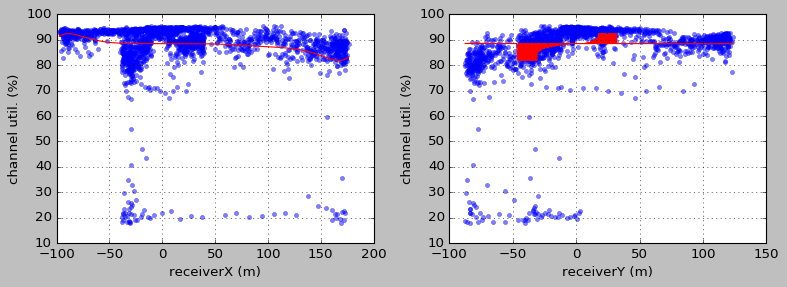

poly regression : {ap type : 802.11n, nr. of clients : 2}
RMSE : 2.8389840606780714
R2 score : 0.06457665189818573


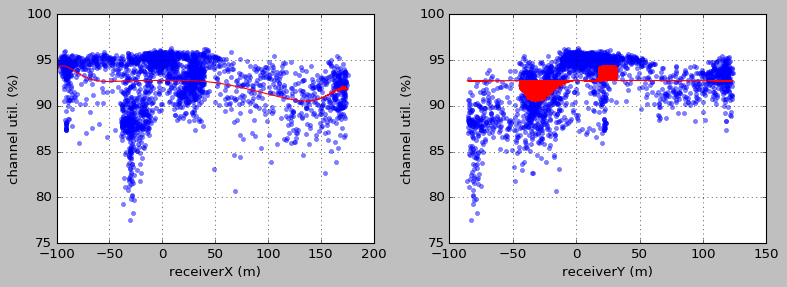

poly regression : {ap type : 802.11n, nr. of clients : 3}
RMSE : 2.83889605324508
R2 score : 0.03765395021388174


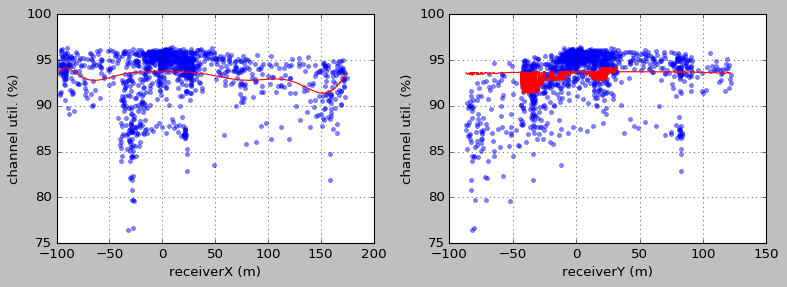

poly regression : {ap type : 802.11ac, nr. of clients : 1}
RMSE : 23.563767585006588
R2 score : 0.42235738835153536


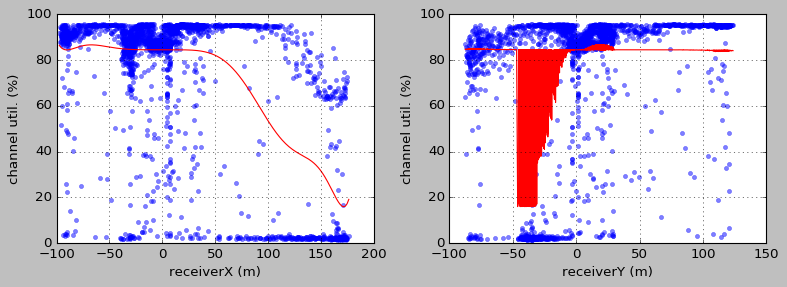

poly regression : {ap type : 802.11ac, nr. of clients : 2}
RMSE : 9.861771854647976
R2 score : 0.16473050555117175


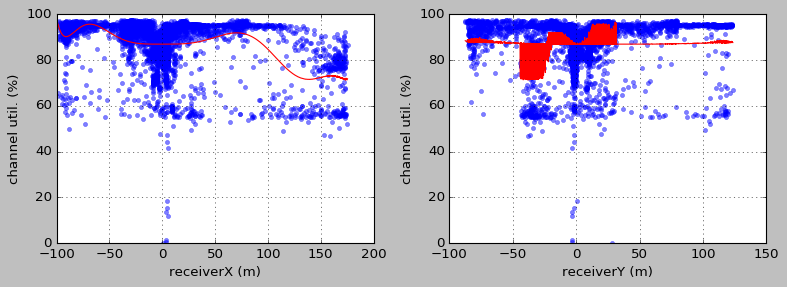

poly regression : {ap type : 802.11ac, nr. of clients : 3}
RMSE : 8.34524425751242
R2 score : 0.35310879789397587


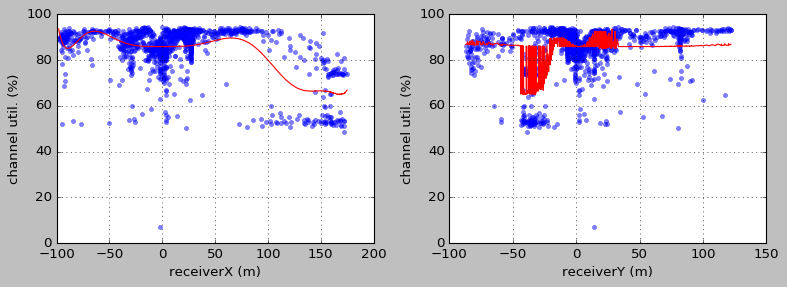

In [47]:
for ap in cbt_generator_data:
    for nr_clients in cbt_generator_data[ap]:
        print('poly regression : {ap type : 802.11%s, nr. of clients : %s}' % (ap.replace('ap-', ''), nr_clients))
        plot_ch_util_training(cbt_generator_data[ap][nr_clients])

### Polynomial regression for channel util.

In [48]:
for trace_nr in trace_nrs:

    gps_data = pd.read_csv(os.path.join(base_dir, ('m1/trace-%s/gps-log.csv' % (trace_nr))))
    gps_data['systime'] = gps_data['timestamp'].astype(int)
    interpol_gps(gps_data, subset = ['lat', 'lon'])
    add_cartesian(gps_data)
    
    for ap in cbt_files:
        
        filename = ('%s/trace-%s/%s' % (cbt_files[ap]['folder'], trace_nr, cbt_files[ap]['file']))
        filename = os.path.join(base_dir, filename)
        
        if not os.path.isfile(filename):
            print('processing trace-%s, ap type : 802.11%s' % (trace_nr, ap.replace('ap-', '')))
            
            cbt_data = cbt_generator_data[ap][trace_info[trace_nr]['nr-clients']]
            
            # convert original x,y features to polynomial 3rd order features
            poly_features = PolynomialFeatures(degree = 5)
            poly_xy = poly_features.fit_transform(cbt_data[['receiverX', 'receiverX']])
            # fit to generator data with linear regression and predict using trace's data
            model = LinearRegression()
            model.fit(poly_xy, cbt_data['channelUtil'])
            
            gps_data['channelUtil'] = model.predict(poly_features.fit_transform(gps_data[['receiverX', 'receiverX']]))
            cbt_dir = os.path.join(base_dir, ('%s/trace-%s' % (cbt_files[ap]['folder'], trace_nr)))
            if not os.path.exists(cbt_dir):
                os.makedirs(cbt_dir)
                
            gps_data[['systime', 'channelUtil']].to_csv(os.path.join(cbt_dir, 'channel-util.csv'), sep = ',', index = False)


## Channel util. for 802.11ad

Here we basically calculate the airtime of all 802.11ad frames captured while in monitor mode (including the contribution of STF, CEF and headers), and then calculate the % of each 1 second period occupied by said frames.

In [49]:
# main sources for these values:
# - 10.1109/IEEESTD.2012.6392842
# - https://www.cs.odu.edu/~cs752/papers/milli-008.pdf
# - http://eprints.networks.imdea.org/1725/1/mmwave-ns3.pdf
ad_preamble_times = {
    'control-phy' : 3.636 + 0.655 + 0.582,
    'single-carrier-phy' : 0.1236 + 0.655 + 0.582,
}

ad_phy_rates = {
    0 : 27.5,
    1 : 385.0,
    2 : 770.0,
    3 : 962.5,
    4 : 1155.0,
    5 : 1251.25,
    6 : 1540.0,
    7 : 1925.0,
    8 : 2310.0,
    9 : 2502.5,
    10 : 3080.0,
    11 : 3850.0, 
    12 : 4620.0,
    13 : 693.00,
    14 : 866.25,
    15 : 1386.00,
}

ad_files = {
    'folder' : 'w4/tp-02',
}

# FIXME : for now, we only use frames in the available .csv files : ad.data, ad.mgmt and ad.sweep
# as these do not represent all the frames captured within some time period, 
# the channel util. value calculated for 802.11ad is thus a lower bound
for trace_nr in trace_nrs:
    
    output_file = ('%s/trace-%s/%s' % (ad_files['folder'], trace_nr, 'channel-util.csv'))
    output_file = os.path.join(base_dir, output_file)
    print(output_file)
    if os.path.isfile(output_file):
        continue
    
    ch_util_data = pd.DataFrame()
    for pcap_file in ['monitor.ad.data.csv', 'monitor.ad.mgmt.csv', 'monitor.ad.sweep.csv']:

        pcap_filename = ('%s/trace-%s/%s' % (ad_files['folder'], trace_nr, pcap_file))
        pcap_filename = os.path.join(base_dir, pcap_filename)
        if not os.path.isfile(pcap_filename):
            continue
        
        print('processing trace-nr : %s, pcap : %s' % (trace_nr, pcap_file))
        
        chunksize = 10 ** 5
        for chunk in pd.read_csv(pcap_filename, chunksize = chunksize):
            
            chunk['data-rate'] = chunk['wlan_radio.11n.mcs_index'].apply(lambda x : ad_phy_rates[x])
            chunk['duration-data'] = (chunk['frame.len'] - chunk['radiotap.length']) / chunk['data-rate']
            chunk['type'] = chunk['wlan.fc.type_subtype'].apply(lambda x : int(x) >> 4).astype(int)
            chunk['duration-preamble'] = chunk['type'].apply(lambda x : ad_preamble_times['control-phy'] if (x not in [2]) else ad_preamble_times['single-carrier-phy'])
            chunk['duration'] = chunk['duration-preamble'] + chunk['duration-data']
    
            ch_util_data = pd.concat([ch_util_data, chunk[['frame.time_epoch', 'type', 'duration']]])
    
    ch_util_data = ch_util_data.sort_values(by = ['frame.time_epoch']).reset_index(drop = True)
    ch_util_data['systime'] = ch_util_data['frame.time_epoch'].astype(int)
    ch_util_data = ch_util_data.groupby(['systime'])['duration'].sum().reset_index(drop = False, name = 'cbt')
    ch_util_data['channelUtil'] = (ch_util_data['cbt'] / 1000000.0) * 100.0
    
    print(ch_util_data['channelUtil'].max())
    
    ch_util_data[['systime', 'channelUtil']].to_csv(output_file, sep = ',', index = False)
    

/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-302/channel-util.csv
/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-303/channel-util.csv
/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-304/channel-util.csv
/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-401/channel-util.csv
/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-402/channel-util.csv
/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-403/channel-util.csv
/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-404/channel-util.csv
/Volumes/data/vehicular-traces-gaia/w4/tp-02/trace-405/channel-util.csv


## Extract beacon reception statistics

Beacon reception statistics include:
* Nr of received beacons
* Beacon inter-arrival time
* Beacon RSSI
* (...)

### 802.11n and 802.11ac beacons

In [125]:
mgmt_files = {
    'm1' : {
        'macaddr' : '24:05:0f:61:51:14',
        'folder' : 'm1',
        'file' : 'monitor.n.mgmt.csv', 
        'type-subtype' : 8,
        'senderId' : 'ap-n'},
    'w4' : {
        'macaddr' : 'c4:e9:84:09:4a:5e',
        'folder' : 'w4/tp-02',
        'file' : 'monitor.ac.mgmt.csv', 
        'type-subtype' : 8,
        'senderId' : 'ap-ac'},
}

def get_beacon_stats(trace_nr):
    
    trace_data = pd.DataFrame()

    for node in mgmt_files:
        
#         print('processing trace : %s, wifi-type : %s' % (trace_nr, mgmt_files[node]['senderId'].replace('ap-', '')))
        filename_beacon = ('%s/trace-%s/%s' % (mgmt_files[node]['folder'], trace_nr, mgmt_files[node]['file']))
        filename_beacon = os.path.join(base_dir, filename_beacon)
        
        if not os.path.isfile(filename_beacon):
            continue
            
        data = pd.read_csv(filename_beacon)
        data = data[data['wlan.fc.type_subtype'] == mgmt_files[node]['type-subtype']]
        data['interBeaconTime'] = data['frame.time_epoch'] - data['frame.time_epoch'].shift(1)
        data['systime'] = data['frame.time_epoch'].astype(int)
        
        if data.empty:
            continue
        
        data = data.groupby(['systime']).agg({'interBeaconTime' : 'mean', 'wlan_radio.signal_dbm' : 'mean', 'frame.time_epoch' : 'size'}).reset_index(drop = False)
        data.rename(index = str, columns = {
            'interBeaconTime' : 'meanInterBeaconTime',
            'wlan_radio.signal_dbm' : 'meanBeaconRssi', 
            'frame.time_epoch' : 'nBeacons'}, inplace = True)

        data['traceNr'] = trace_nr
        data['receiverId'] = node
        data['senderId'] = mgmt_files[node]['senderId']
        data['wifiType'] = mgmt_files[node]['senderId'].replace('ap-', '')
        data['meanBeaconRssi'] = data['meanBeaconRssi'].fillna(-100.0)
        
        trace_data = pd.concat([trace_data, data])
    
    return trace_data
    

In [126]:
trace_nrs = ['302', '303', '304', '401', '402', '403', '404', '405']
beacon_data = pd.DataFrame()
for trace_nr in trace_nrs:
    print('processing trace %s' % (trace_nr))
    beacon_data = pd.concat([beacon_data, get_beacon_stats(trace_nr)])
    

processing trace 302
processing trace 303
processing trace 304
processing trace 401
processing trace 402
processing trace 403
processing trace 404
processing trace 405


### 802.11ad DMG beacons

In [127]:
ad_mac_addrs = {'ap' : '50:c7:bf:97:8a:a6', 'tp-03' : '50:c7:bf:3c:53:1c', 'tp-01' : '70:4f:57:72:b2:58'}

mgmt_files = {
    'tp-03' : {
        'macaddr' : '50:c7:bf:3c:53:1c',
        'folder' : 'w4/tp-02',
        'file' : 'monitor.ad.dmg.csv', 
        'receiverId' : 'tp-03',
        'type-subtype' : 8,
        'senderId' : 'ap-ad'},
}

# extract rssi from ssw-feedback and ssw-feedback-ack frames
def get_80211ad_dmg_beacon_stats(trace_nr, node = 'tp-03'):
    
    dmg_data = pd.read_csv(os.path.join(base_dir, ('w4/tp-02/trace-%s/monitor.ad.dmg.csv' % (trace_nr))))
    # filter true dmg beacons only
    dmg_data = dmg_data[(dmg_data['wlan.fc.type_subtype'] == 48) & (dmg_data['frame.len'] == 52)]
    if dmg_data.empty:
        return dmg_data
        
    # find beacon transmission intervals (bti) : started by a reset of wlan.ssw.cdown
    dmg_data['bti'] = (dmg_data['wlan.ssw.cdown'].shift(1) < dmg_data['wlan.ssw.cdown']).astype(int).cumsum()
    # group by bti and take the first timestamp as the 'beacon timestamp'
    dmg_data = dmg_data.groupby(['bti']).agg({'frame.time_epoch' : 'min', 'wlan.ssw.cdown' : 'size'}).reset_index(drop = False)
    
    dmg_data['interBeaconTime'] = dmg_data['frame.time_epoch'] - dmg_data['frame.time_epoch'].shift(1)
    dmg_data['systime'] = dmg_data['frame.time_epoch'].astype(int)
    
    dmg_data = dmg_data.groupby(['systime']).agg({'interBeaconTime' : 'mean', 'frame.time_epoch' : 'size'}).reset_index(drop = False)
    dmg_data.rename(index = str, columns = {
        'interBeaconTime' : 'meanInterBeaconTime',
        'frame.time_epoch' : 'nBeacons'}, inplace = True)

    dmg_data['traceNr'] = trace_nr
    dmg_data['receiverId'] = node
    dmg_data['senderId'] = 'ap-ad'
    dmg_data['wifiType'] = 'ad'
    dmg_data['meanBeaconRssi'] = -100.0
    
    return dmg_data

In [131]:
for trace_nr in trace_nrs:
    print('processing trace %s' % (trace_nr))
    ad_beacon_data = get_80211ad_dmg_beacon_stats(trace_nr)
    beacon_data = pd.concat([beacon_data, ad_beacon_data])
    
print(list(beacon_data.columns))

processing trace 302
processing trace 303
processing trace 304
processing trace 401
processing trace 402
processing trace 403
processing trace 404
processing trace 405
['meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons', 'receiverId', 'senderId', 'systime', 'traceNr', 'wifiType']


In [130]:
output_file = os.path.join(base_dir, 'beacon-stats.csv')
if not os.path.isfile(output_file):
    beacon_data.to_csv(output_file, sep = ',', index = False)

## Add throughput as measured by consumer app

### Definitions and functions

In [168]:
tghpt_files = {
    'm1' : {
        'folder' : 'm1',
        'file' : 'consumer.1.out', 
        'senderId' : 'ap-n'}, 
    'w4' : {
        'folder' : 'w4',
        'file' : 'consumer.1.out', 
        'senderId' : 'ap-ac'},
    'tp-03' : {
        'folder' : 'w4/tp-03',
        'file' : 'consumer.5202.1.out', 
        'receiverId' : 'tp-03',
        'senderId' : 'ap-ad'},
#     'w2-bck-n' : {
#         'folder' : 'w2',
#         'file' : 'consumer.5203.1.out',
#         'senderId' : 'ap-n'},
#     'w2-bck-ac' : {
#         'folder' : 'w2',
#         'file' : 'consumer.5204.1.out',
#         'senderId' : 'ap-ac'},
#     'w3-bck-n' : {
#         'folder' : 'w3',
#         'file' : 'consumer.5205.1.out',
#         'senderId' : 'ap-n'},
#     'w3-bck-ac' : {
#         'folder' : 'w3',
#         'file' : 'consumer.5206.1.out', 
#         'senderId' : 'ap-ac'},
#     'tp-01' : {
#         'folder' : 'b1/tp-01',
#         'file' : 'consumer.5204.1.out',
#         'senderId' : 'ap-ad'},
}

trace_info = {
    '301' : {'n' : 1, 'ac' : 1, 'ad' : 1, },
    '302' : {'n' : 1, 'ac' : 1, 'ad' : 1, },
    '303' : {'n' : 2, 'ac' : 2, 'ad' : 2, },
    '304' : {'n' : 3, 'ac' : 3, 'ad' : 2, },
    '401' : {'n' : 1, 'ac' : 1, 'ad' : 1, },
    '402' : {'n' : 2, 'ac' : 2, 'ad' : 2, },
    '403' : {'n' : 2, 'ac' : 2, 'ad' : 2, },
    '404' : {'n' : 2, 'ac' : 2, 'ad' : 2, },
    '405' : {'n' : 2, 'ac' : 2, 'ad' : 2, },
}

cbt_files = {
    'ap-n' : {
        'folder' : 'b1/it-unifi-003', 
        'file' : 'channel-util.csv'}, 
    'ap-ac' : {
        'folder' : 'b1/it-unifi-001', 
        'file' : 'channel-util.csv'},
    'ap-ad' : {
        'folder' : 'w4/tp-02', 
        'file' : 'channel-util.csv'}
}

# get throughput data for each 802.11 type (n, ac, ad)
def get_thghpt(trace_nr):

    trace_data = pd.DataFrame()

    for node in tghpt_files:
        
        filename_tghpt = ('%s/trace-%s/%s' % (tghpt_files[node]['folder'], trace_nr, tghpt_files[node]['file']))
        filename_tghpt = os.path.join(base_dir, filename_tghpt)
        
        if not os.path.isfile(filename_tghpt):
            continue
        
        tghpt_data = pd.read_csv(filename_tghpt, names = ['systime', 'rcvd-pkt', 'rcvd-bytes', 'duration', 'thghpt-consumer'])
    
        tghpt_data['traceNr'] = trace_nr
        tghpt_data['wifiType'] = ('%s' % (tghpt_files[node]['senderId'].replace('ap-', '')))

        trace_data = pd.concat([trace_data, tghpt_data])
    
    return trace_data
    

### Extract consumer throughput for all traces

In [169]:
# total nr. of clients per trace nr. (including background clients)
trace_nrs = ['302', '303', '304', '401', '402', '403', '404', '405']
tghpt_data = pd.DataFrame()
for trace_nr in trace_nrs:
    print('processing trace %s' % (trace_nr))
    tghpt_data = pd.concat([tghpt_data, get_thghpt(trace_nr)])
    

processing trace 302
processing trace 303
processing trace 304
processing trace 401
processing trace 402
processing trace 403
processing trace 404
processing trace 405


In [170]:
# make sure there's an equal number of samples for each 802.11 type
# for timestamps in which an 802.11 type doesn't have data, we either: 
# - interpolate throughput : if gap is small (< 5 sec)
# - set throughput to 0.0
trace_data = pd.DataFrame()
for trace_nr in trace_nrs:
    
    timestamps = tghpt_data[tghpt_data['traceNr'] == trace_nr].sort_values(by = ['systime'])['systime'].unique()
    timestamps = np.arange(timestamps.min(), timestamps.max() + 1.0, 1.0)
    
    for i, node in enumerate(tghpt_files):
        
        wifi_type = tghpt_files[node]['senderId'].replace('ap-', '')
    
        wifi_type_data = pd.DataFrame()
        wifi_type_data['systime'] = timestamps
        
        # add throughput data
        wifi_type_data = pd.merge(wifi_type_data, tghpt_data[(tghpt_data['wifiType'] == wifi_type) & (tghpt_data['traceNr'] == trace_nr)][['systime', 'thghpt-consumer']], on = ['systime'], how = 'left')

        # add cbt data
        ap = tghpt_files[node]['senderId']
        filename_cbt = ('%s/trace-%s/%s' % (cbt_files[ap]['folder'], trace_nr, cbt_files[ap]['file']))
        filename_cbt = os.path.join(base_dir, filename_cbt)
        cbt_data = pd.read_csv(filename_cbt)
        wifi_type_data = pd.merge(wifi_type_data, cbt_data[['systime', 'channelUtil']], on = 'systime', how = 'left')
        
        # add beacon data
        beacon_data = pd.read_csv(os.path.join(base_dir, 'beacon-stats.csv'))
        beacon_data['systime'] = beacon_data['systime'].astype(float)
        beacon_data = beacon_data[(beacon_data['traceNr'] == int(trace_nr)) & (beacon_data['wifiType'] == wifi_type)]
        wifi_type_data = pd.merge(wifi_type_data, beacon_data[['systime', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons']], on = ['systime'], how = 'left')
        
        # interpolate or zero missing data
        # - interpol (max. 5 sec gaps)
        interpol(wifi_type_data, subset = ['thghpt-consumer', 'channelUtil', 'meanInterBeaconTime'], timedate_column = 'systime', limit = 5)
        # - fill remaining nans with 0.0, -1.0
        wifi_type_data['thghpt-consumer'] = wifi_type_data['thghpt-consumer'].fillna(0.0)
        wifi_type_data['channelUtil'] = wifi_type_data['channelUtil'].fillna(-1.0)
        wifi_type_data['meanInterBeaconTime'] = wifi_type_data['meanInterBeaconTime'].fillna(1.0)
        wifi_type_data['nBeacons'] = wifi_type_data['nBeacons'].fillna(0.0)
        wifi_type_data['meanBeaconRssi'] = wifi_type_data['meanBeaconRssi'].fillna(-100.0)
        
        # fill remaining columns
        wifi_type_data['nrClients'] = trace_info[trace_nr][('%s' % (wifi_type))]
        wifi_type_data['receiverId'] = node
        wifi_type_data['senderId'] = tghpt_files[node]['senderId']
        wifi_type_data['traceNr'] = trace_nr
        wifi_type_data['wifiType'] = wifi_type
#         wifi_type_data['systime'] = wifi_type_data['systime'].astype(int)
        
        trace_data = pd.concat([trace_data, wifi_type_data])
        

In [171]:
# add gps data
gps_data_total = pd.DataFrame()
for trace_nr in trace_nrs:
    
    gps_data_orig = pd.read_csv(os.path.join(base_dir, ('m1/trace-%s/gps-log.csv' % (trace_nr))))
    gps_data_orig['systime'] = gps_data_orig['timestamp'].astype(int)
    
    gps_data_interpol = pd.DataFrame()
    gps_data_interpol['systime'] = trace_data[(trace_data['traceNr'] == trace_nr)].sort_values(by = ['systime'])['systime'].unique()
    gps_data_interpol = pd.merge(gps_data_interpol, gps_data_orig, on = ['systime'], how = 'left')
    # gps (lat, lon) interpolation
    interpol(gps_data_interpol, subset = ['lat', 'lon', 'alt', 'speed'])
    # add cartesian coordinates
    add_cartesian(gps_data_interpol)
    
    gps_data_total = pd.concat([gps_data_total, gps_data_interpol])
    
# merge trace_data w/ gps data
trace_data = pd.merge(trace_data, gps_data_total[['systime', 'speed', 'lon', 'lat', 'alt', 'receiverX', 'receiverY', 'receiverDist']], on = ['systime'], how = 'left')

In [172]:
# remove nans outside valid values, which haven't been interpolated
trace_data = trace_data.dropna(subset = ['lat', 'lon']).sort_values(by = ['systime']).reset_index(drop = True)
# rename columns
trace_data.rename(index = str, columns = {
    'speed' : 'receiverSpeed',
    'alt' : 'receiverAlt',
    'thghpt-consumer' : 'tghptConsumer'}, inplace = True)

# additional columns
trace_data['isIperfOn'] = 1
trace_data['isInLap'] = 1
trace_data['channelBw'] = 0.0
for ap in ap_info:
    trace_data.loc[trace_data['senderId'] == ap, 'channelBw'] = ap_info[ap]['bw']

In [173]:
for trace_nr in trace_nrs:
    for i, node in enumerate(tghpt_files):
        wifi_type = tghpt_files[node]['senderId'].replace('ap-', '')
        wifi_type_data = trace_data[(trace_data['traceNr'] == trace_nr) & (trace_data['wifiType'] == wifi_type)]
        print('%s, %s, %s, %s, %s' % (trace_nr, wifi_type, len(wifi_type_data), len(wifi_type_data[wifi_type_data['tghptConsumer'] > 0.0]), len(wifi_type_data[wifi_type_data['channelUtil'] > -1.0])))

302, n, 3312, 3243, 3311
302, ac, 3312, 2914, 3311
302, ad, 3312, 225, 948
303, n, 3482, 3278, 3480
303, ac, 3482, 3154, 3481
303, ad, 3482, 277, 1022
304, n, 1916, 1701, 1734
304, ac, 1916, 1651, 1737
304, ad, 1916, 81, 171
401, n, 1685, 1685, 1685
401, ac, 1685, 1684, 1685
401, ad, 1685, 460, 838
402, n, 2859, 2859, 2859
402, ac, 2859, 2858, 2859
402, ad, 2859, 452, 1210
403, n, 135, 135, 135
403, ac, 135, 134, 135
403, ad, 135, 83, 135
404, n, 114, 114, 114
404, ac, 114, 113, 114
404, ad, 114, 51, 114
405, n, 2019, 2017, 2019
405, ac, 2019, 2018, 2019
405, ad, 2019, 352, 1159


In [174]:
print(trace_data)

               systime  tghptConsumer  channelUtil  meanBeaconRssi  \
0     1566296925.00000        1.66000     -1.00000       -34.50000   
1     1566296925.00000        0.00000     15.19276      -100.00000   
2     1566296925.00000        0.00000     -1.00000      -100.00000   
3     1566296926.00000       15.86200     12.10676      -100.00000   
4     1566296926.00000      413.87900     12.15730      -100.00000   
...                ...            ...          ...             ...   
46561 1566476324.00000      144.36200     71.55340      -100.00000   
46562 1566476324.00000        0.00000     11.75873      -100.00000   
46563 1566476325.00000       40.06200     93.34841       -32.50000   
46564 1566476325.00000      148.79000     71.55340      -100.00000   
46565 1566476325.00000        0.00000     11.09749      -100.00000   

       meanInterBeaconTime  nBeacons  nrClients receiverId senderId traceNr  \
0                  0.12818   8.00000          1         m1     ap-n     302   
1

## Generate final .csv, for all traces

### 802.11ad .pcap file pre-processing

802.11ad .pcap files require special pre-processing to extract the following fields:

* rssiMean (wlan_radio.signal_dbm) : Retrieved from sector sweep frames. Namely from the `wlan.sswf.snr_report` field of ssw-feedback (type 361) and ssw-feedback-ack (type 362) frames.
* dataRateMean (wlan_radio.data_rate) : Retrieved from the `wlan_radio.11n.mcs_index` field. 


In [175]:
ad_phy_rates = {
    0 : 27.5,
    1 : 385.0,
    2 : 770.0,
    3 : 962.5,
    4 : 1155.0,
    5 : 1251.25,
    6 : 1540.0,
    7 : 1925.0,
    8 : 2310.0,
    9 : 2502.5,
    10 : 3080.0,
    11 : 3850.0, 
    12 : 4620.0,
    13 : 693.00,
    14 : 866.25,
    15 : 1386.00,
}

ad_mac_addrs = {'ap' : '50:c7:bf:97:8a:a6', 'tp-03' : '50:c7:bf:3c:53:1c', 'tp-01' : '70:4f:57:72:b2:58'}

# convert 'wlan.sswf.snr_report' field value to dBm
def convert_snr(data):
    # wlan.sswf.snr_report : encoded as 8-bit twos complement value of 4×(SNR-19), where SNR is measured in dB    
    msbs = ((data[data['wlan.fc.type_subtype'] > 360]['wlan.sswf.snr_report'].astype(int) & 0x0080)).values
    msbs = np.array([ float((int(msb) >> 7) * -128.0) for msb in msbs ])
    lsbs = data[data['wlan.fc.type_subtype'] > 360]['wlan.sswf.snr_report'] + msbs
        
    data['wlan.sswf.snr_report.converted'] = 0.0
    data.loc[data['wlan.fc.type_subtype'] > 360, 'wlan.sswf.snr_report.converted'] = ((lsbs + msbs) / 4.0) + 19.0

# extract rssi from ssw-feedback and ssw-feedback-ack frames
def get_80211ad_rssi(trace_nr, node = 'tp-03'):
    sweep_data = pd.read_csv(os.path.join(base_dir, ('w4/tp-02/trace-%s/monitor.ad.sweep.csv' % (trace_nr))))
    sweep_data['systime'] = sweep_data['frame.time_epoch'].astype(int)
    # keep feedback frames w/ wlan.sswf.snr_report as seen by client
    sweep_data = sweep_data[(sweep_data['wlan.fc.type_subtype'].isin([361, 362])) & (sweep_data['wlan.ta'] == ad_mac_addrs['tp-03'])].reset_index(drop = True)
    # convert wlan.sswf.snr_report to dBm rssis
    convert_snr(sweep_data)
    sweep_data.rename(index = str, columns = {'wlan.sswf.snr_report.converted' : 'rssi', 'wlan.ta' : 'receiverId'}, inplace = True)
    
    sweep_rssi = sweep_data.groupby(['systime', 'receiverId'])['rssi'].mean().reset_index(drop = False, name = 'rssiMean')
    return sweep_rssi[['systime', 'receiverId', 'rssiMean']].reset_index(drop = True)
    
def fix_80211ad_data_rate(data):
    # data rate
    data['wlan_radio.data_rate'] = data['wlan_radio.11n.mcs_index'].apply(lambda x : ad_phy_rates[int(x)])
    

### Functions & definitions : add features from `tcpdump` captures and append to final .csv

In [176]:
pcap_files = {
    'm1' : {
        'macaddr' : '24:05:0f:61:51:14',
        'folder' : 'm1',
        'file' : 'monitor.n.data.csv', 
        'senderId' : 'ap-n'},
    'w4' : {
        'macaddr' : 'c4:e9:84:09:4a:5e',
        'folder' : 'w4/tp-02',
        'file' : 'monitor.ac.data.csv', 
        'senderId' : 'ap-ac'},
    'tp-03' : {
        'macaddr' : '50:c7:bf:3c:53:1c',
        'folder' : 'w4/tp-02',
        'file' : 'monitor.ad.data.csv', 
        'receiverId' : 'tp-03',
        'senderId' : 'ap-ad'},
#     'w2-bck-n' : {
#         'macaddr' : 'c4:6e:1f:25:cb:df',
#         'folder' : 'm1',
#         'file' : 'monitor.n.data.csv',
#         'senderId' : 'ap-n'},
#     'w2-bck-ac' : {
#         'macaddr' : '24:05:0f:61:52:99',
#         'folder' : 'w4/tp-02',
#         'file' : 'monitor.ac.data.csv',
#         'senderId' : 'ap-ac'},
#     'w3-bck-n' : {
#         'macaddr' : 'c4:6e:1f:25:d7:d8',
#         'folder' : 'm1',
#         'file' : 'monitor.n.data.csv',
#         'senderId' : 'ap-n'},
#     'w3-bck-ac' : {
#         'macaddr' : '24:05:0f:aa:ab:5d',
#         'folder' : 'w4/tp-02',
#         'file' : 'monitor.ac.data.csv', 
#         'senderId' : 'ap-ac'},
#     'tp-01' : {
#         'macaddr' : '70:4f:57:72:b2:58',
#         'folder' : 'w4/tp-02',
#         'file' : 'monitor.ad.data.csv',
#         'senderId' : 'ap-ad'},
}

final_columns = ['systime', 'traceNr', 'lon', 'lat', 'receiverAlt', 'receiverX', 'receiverY', 'receiverDist', 'receiverSpeed', 'receiverId', 'senderId', 'isIperfOn', 'isInLap', 'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMedian', 'dataRateMean', 'nBytesReceived', 'tghptConsumer', 'wifiType', 'nrClients', 'nRetries', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons']

def extract_pcap_data(data, trace_nr, save_csv = False, csv_filename = os.path.join(base_dir, 'final-exp-log.csv')):
    
    for node in pcap_files:
                
        filename = ('%s/trace-%s/%s' % (pcap_files[node]['folder'], trace_nr, pcap_files[node]['file']))
        filename = os.path.join(base_dir, filename)
        if not os.path.isfile(filename):
            continue
        
        pcap_data = pd.DataFrame()
        chunksize = 10 ** 5
        for chunk in pd.read_csv(filename, chunksize = chunksize):
            
            chunk = chunk[(chunk['wlan.ra'] == pcap_files[node]['macaddr']) | (chunk['wlan.ta'] == pcap_files[node]['macaddr'])]
            chunk['systime'] = chunk['frame.time_epoch'].astype(int)
            
            udp_data = chunk[(chunk['ip.proto'] == 17.0)]
            # fix 802.11ad data rate values
            if node in ['tp-03', 'tp-01']:
                fix_80211ad_data_rate(udp_data)
                
            udp_data = udp_data.groupby(['systime']).agg({'frame.len' : 'sum', 'wlan_radio.data_rate' : ['median', 'mean'], 'wlan_radio.signal_dbm' : 'mean', 'wlan.fc.retry' : 'sum'})
            udp_data.columns = udp_data.columns.map('.'.join)
            udp_data = udp_data.reset_index(drop = False)
            udp_data.rename(index = str, columns = {
                'systime.' : 'systime',
                'frame.len.sum' : 'nBytesReceived', 
                'wlan_radio.data_rate.mean' : 'dataRateMean',
                'wlan_radio.data_rate.median' : 'dataRateMedian',
                'wlan_radio.signal_dbm.mean' : 'rssiMean',
                'wlan.fc.retry.sum' : 'nRetries'}, inplace = True)
            
            pcap_data = pd.concat([pcap_data, udp_data])
        
        pcap_data = pcap_data.groupby(['systime']).agg({'nBytesReceived' : 'sum', 'dataRateMean' : 'mean', 'dataRateMedian' : 'median', 'rssiMean' : 'mean', 'nRetries' : 'sum'})
        pcap_data = pcap_data.reset_index(drop = False)
        pcap_data.rename(index = str, columns = {
            'nBytesReceived.sum' : 'nBytesReceived', 
            'dataRateMean.mean' : 'dataRateMean',
            'dataRateMedian.median' : 'dataRateMedian',
            'rssiMean.mean' : 'rssiMean',
            'nRetries.sum' : 'nRetries'}, inplace = True)
        
        pcap_data = pd.merge(data[(data['receiverId'] == node) & (data['traceNr'] == trace_nr)], pcap_data[['systime', 'rssiMean', 'dataRateMedian', 'dataRateMean', 'nBytesReceived', 'nRetries']], on = ['systime'], how = 'left')        
        print('trace nr : %s, wifi type : %s' % (trace_nr, pcap_files[node]['senderId'].replace('ap-', '')))
        print(len(pcap_data))
        
        # add 802.11ad rssi data (retrieved from sector sweep frames)
        if node in ['tp-03', 'tp-01']:
            ad_rssi_data = get_80211ad_rssi(trace_nr, node)
            pcap_data = pcap_data.drop(columns = ['rssiMean'])
            pcap_data = pd.merge(pcap_data, ad_rssi_data[['systime', 'rssiMean']], on = ['systime'], how = 'left')

        # interpolate continuous variables
        interpol(pcap_data, subset = ['nBytesReceived', 'dataRateMean', 'rssiMean'], limit = 5)
        pcap_data[['nBytesReceived', 'dataRateMean', 'nRetries']] = pcap_data[['nBytesReceived', 'dataRateMean', 'nRetries']].fillna(0.0)
        # missing rssi filled w/ -100 dBm
        pcap_data['rssiMean'] = pcap_data['rssiMean'].fillna(-100.0)
        # ffill dataRateMedian
        pcap_data['dataRateMedian'] = pcap_data['dataRateMedian'].fillna(method = 'ffill', limit = 5)
        pcap_data['dataRateMedian'] = pcap_data['dataRateMedian'].fillna(0.0)
        pcap_data['channelFreq'] = ap_info[pcap_files[node]['senderId']]['freq']
        
        pcap_data = pcap_data[final_columns].dropna()
        print(len(pcap_data))
        
        if save_csv:
            if not os.path.isfile(csv_filename):
                pcap_data.to_csv(csv_filename, sep = ',', index = False)
            else:
                pcap_data.to_csv(csv_filename, sep = ',', mode = 'a', header = False, index = False)


### Iteratively generate final .csv, trace by trace

In [177]:
final_csv = os.path.join(base_dir, 'final-exp-log.csv')
if not os.path.isfile(final_csv):
    for trace_nr in trace_nrs:
        print('processing trace %s' % (trace_nr))
        extract_pcap_data(trace_data, trace_nr, save_csv = True, csv_filename = final_csv)

processing trace 302
trace nr : 302, wifi type : n
3312
3312
trace nr : 302, wifi type : ac
3312
3312
trace nr : 302, wifi type : ad
3312
3312
processing trace 303
trace nr : 303, wifi type : n
3482
3482
trace nr : 303, wifi type : ac
3482
3482
trace nr : 303, wifi type : ad
3482
3482
processing trace 304
trace nr : 304, wifi type : n
1916
1916
trace nr : 304, wifi type : ac
1916
1916
trace nr : 304, wifi type : ad
1916
1916
processing trace 401
trace nr : 401, wifi type : n
1685
1685
trace nr : 401, wifi type : ac
1685
1685
trace nr : 401, wifi type : ad
1685
1685
processing trace 402
trace nr : 402, wifi type : n
2859
2859
trace nr : 402, wifi type : ac
2859
2859
trace nr : 402, wifi type : ad
2859
2859
processing trace 403
trace nr : 403, wifi type : n
135
135
trace nr : 403, wifi type : ac
135
135
trace nr : 403, wifi type : ad
135
135
processing trace 404
trace nr : 404, wifi type : n
114
114
trace nr : 404, wifi type : ac
114
114
trace nr : 404, wifi type : ad
114
114
processing 

### Scatter plots

Use this to visualize 2 variables against each other.

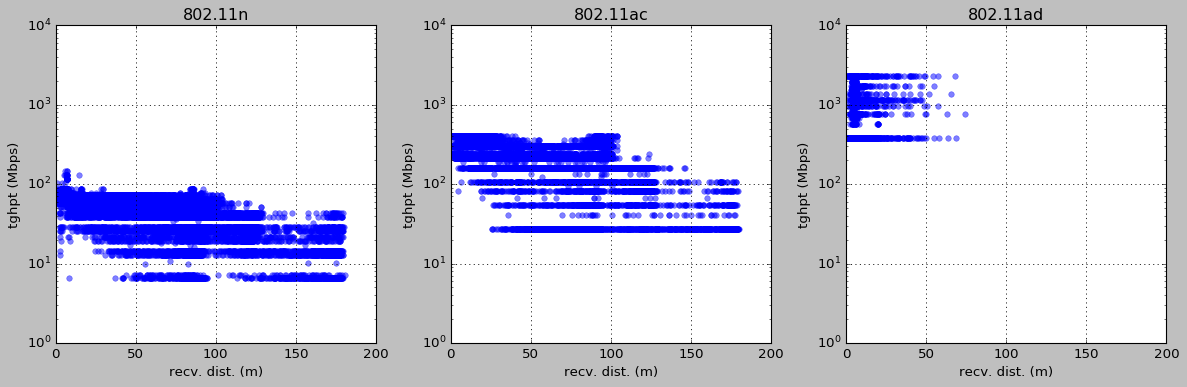

In [153]:
base_filename = "/Volumes/data/vehicular-traces-gaia/final-exp-log.csv"
dataset = pd.read_csv(base_filename)

plt.style.use('classic')
fig = plt.figure(figsize = ((5.0) * 3, (5.0)))

for i, wifi_type in enumerate(['n', 'ac', 'ad']):
    plot_data = dataset[dataset['wifiType'] == wifi_type].sort_values(by = ['receiverDist'])

    ax = fig.add_subplot(1, 3, i + 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.set_title('802.11%s' % (wifi_type))
    ax.plot(plot_data['receiverDist'], plot_data['dataRateMedian'], color = 'blue', linewidth = 0.0, marker = '.', markersize = 10.0, alpha = .5)
    ax.set_xlabel('recv. dist. (m)')
    ax.set_xlim([0.0, 200.0])
    ax.set_ylabel('tghpt (Mbps)')
    ax.set_ylim([1.0, 10000.0])
    ax.set_yscale('log', nonposy = 'clip')
    
fig.tight_layout()
plt.show()

In [154]:
dataset['dataRateMedian'] = dataset['dataRateMedian'].round()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dataset.groupby(['dataRateMedian']).size().reset_index(drop = False, name = 'count').sort_values(by = ['dataRateMedian']))

    dataRateMedian  count
0          0.00000  15836
1          6.00000    801
2          7.00000    131
3         10.00000      4
4         11.00000      1
5         13.00000    475
6         14.00000    581
7         16.00000      1
8         17.00000      3
9         18.00000      2
10        20.00000    317
11        21.00000      5
12        22.00000    340
13        23.00000      1
14        24.00000      1
15        26.00000    837
16        27.00000   1329
17        29.00000    707
18        32.00000      1
19        34.00000      2
20        36.00000      1
21        39.00000    937
22        40.00000     40
23        41.00000      4
24        43.00000   1316
25        46.00000      4
26        51.00000      7
27        52.00000    596
28        54.00000    483
29        55.00000      7
30        58.00000   1141
31        61.00000      7
32        62.00000     12
33        65.00000   2743
34        67.00000      1
35        68.00000     11
36        69.00000     51
37        72